<a href="https://colab.research.google.com/github/aKaSh-7021/Loan-Status-Prediction/blob/main/Loan_status_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><font size="5">Loan Status Prediction</font></h1>


In [1]:
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

### About dataset


This is a historical dataset about past loans status. The dataset includes details of 346 customers whose loan are either already paid off or defaulted. The fields included in the dataset are as follows:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


### Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-08-03 17:11:35--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2021-08-03 17:11:35 (1.81 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load data from CSV file


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


# # Data Visualization


### Let's look at the shape of the dataset:

In [4]:
df.shape

(346, 10)

Number of rows: 346

Number of columns: 10

### Convert to date time object:

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Let’s see how many of each class is in our dataset:


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


### Let's plot some columns to underestand data better:


#### Loan status by basic principal loan amount:

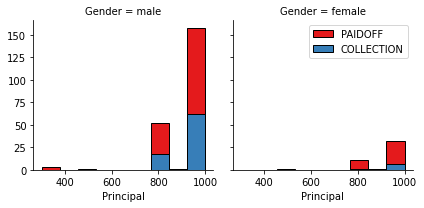

In [7]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

#### Loan status by age of the applicants:

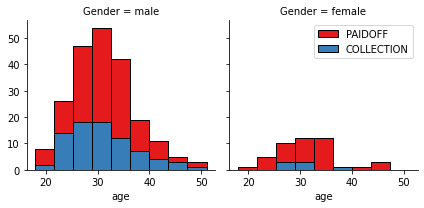

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

#### Loan status by day of the week when people get the loan:

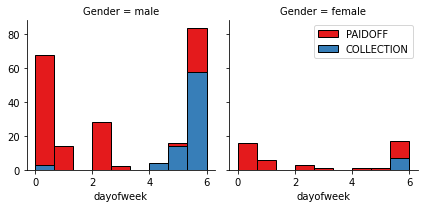

In [9]:
# Extracting the day of week from 'effective_date' to a new variable 'dayofweek'
df['dayofweek'] = df['effective_date'].dt.dayofweek

bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


people who get the loan at the weekends generally don't pay it off

#### Loan status percentage by gender of the applicants:


In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


# # Pre-processing:  Feature Selection & Extraction

## Feature Extraction

We saw that people who get the loan at the end of the week don't pay it off, so let's create a new variable 'weekend' using feature binarization to set a threshold value less than day 4

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convertion of Categorical features into Numerical values

### Let's convert gender into a binary variable:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### One Hot Encoding:

#### How about education?


In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding:

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Convert categorical varables to binary variables and append them to the feature dataframe:

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


## Feature Selection


### Let's define feature set X:


In [16]:
X = Feature
feature_names = X.columns
print(feature_names)
X[0:5]

Index(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Let's define the target variable y:


In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Data Normalization


**Normalization or Standardization**: A standard scaling technique to transform the entire feature set into a common scale.


In [18]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Spliting the dataset into Trainning and Validation sets
**Validation Set:** Having a separate validation set opens up the scope for regularising the classifiers to obtain the optimal parameters.

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=1)

# # Classification

We'll use the following algorithms to train a model to predict wheather if a customer if given a loan in the future would pay back on time or default:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression


## 1. K-Nearest Neighbors (KNN)


In [20]:
# Import KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

### Finding the Optimal Value of K:

#### The optimal K value is usually found ito be the square root of size of training set but we'll check the accuracy of the clissifier for different values of k

In [21]:
# Computing the accuracy for K values in range of 1 to 50

accuracy = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors= i, weights='uniform')
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_val)
    acc = accuracy_score(y_val, pred_i)
    accuracy.append(acc)

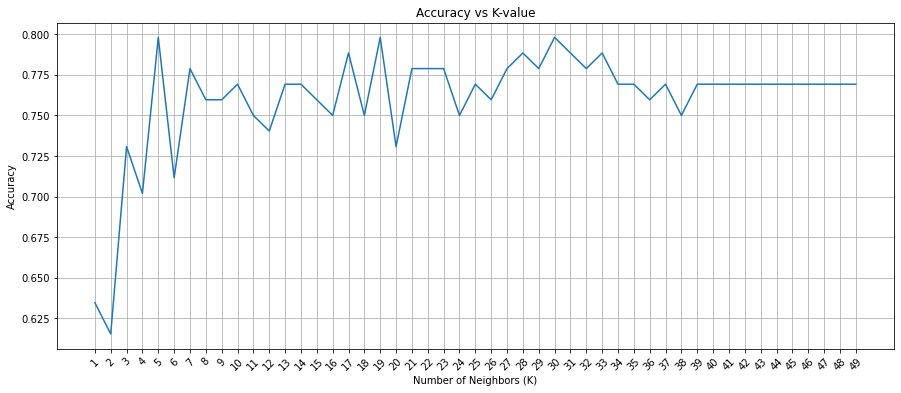

In [22]:
# Accuracy vs K-value Plot

plt.figure(figsize=(15,6))
plt.plot(range(1,50), accuracy)
plt.xticks(list(range(1,50)), rotation=45)
plt.title("Accuracy vs K-value")
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.grid()

#### Accuracy: we get the best results for  k = 19

### Final Trainning:
### let's train KNN classifier using k-value = 19

In [23]:
knn_clf = KNeighborsClassifier(n_neighbors = 19)
knn_clf.fit(X_train, y_train)
pred_knn = knn_clf.predict(X_val)
accuracy = accuracy_score(y_val, pred_knn)
print("accuracy: ", accuracy*100,'%')

accuracy:  79.8076923076923 %


## 2. Decision Tree


In [24]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

### Finding the optimal parameters:

In [25]:
from sklearn.model_selection import GridSearchCV

par_dt = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 'max_features': [1,2,3,4,5,6,7,8], 'random_state': [0,10,20,40,60,100], 'criterion': ['gini','entropy'],}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = par_dt, cv = 10)
grid_dt.fit(X_train, y_train)

print(f"Best Score: {grid_dt.best_score_}")
print(f"Best parameters: {grid_dt.best_params_}")

Best Score: 0.7481666666666666
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'random_state': 40}


### Final Trainning:
### let's train Decision Tree classifier using the best parameters

In [26]:
dt_clf = DecisionTreeClassifier(max_depth = 6, criterion = 'entropy', max_features = 4, random_state = 20)
dt_clf.fit(X_train, y_train)
pred_dt = dt_clf.predict(X_val)
accuracy = accuracy_score(y_val, pred_dt)
print("accuracy: ", accuracy*100,'%')

accuracy:  71.15384615384616 %


#### Let's install pydotplus for visualizing the tree:

In [27]:
!pip install pydotplus

#### Visual representation of the decision tree classifier:

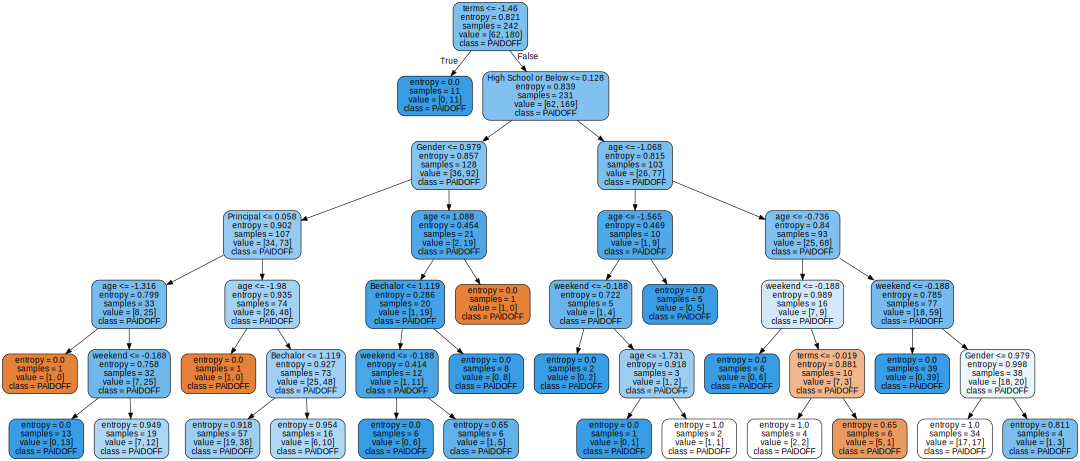

In [28]:
import pydotplus
import graphviz
from sklearn.tree import export_graphviz

tree_viz = export_graphviz( dt_clf, out_file = None, feature_names = feature_names, class_names = y, rounded=True, filled=True)
pydot_graph = pydotplus.graph_from_dot_data(tree_viz)
pydot_graph.set_size('"15,15!"')
pydot_graph.write_png('resized_tree.png')

gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

## 3. Support Vector Machine


In [29]:
# Import Support Vector Machine Classifier
from sklearn.svm import SVC

In [30]:
par_svm = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear','rbf','poly']} 

grid_svm = GridSearchCV( SVC(), param_grid = par_svm, cv = 10)
grid_svm.fit(X_train, y_train)

print(f"Best Score: {grid_svm.best_score_}")
print(f"Best parameters: {grid_svm.best_params_}")

Best Score: 0.744
Best parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


### Final Training:
### let's train SVM classifier using the best parameters

In [31]:
svm_clf = SVC(C = 0.1, gamma = 1, kernel = 'linear')
svm_clf.fit(X_train, y_train)

pred_svm = dt_clf.predict(X_val)
accuracy = accuracy_score(y_val, pred_svm)
print("accuracy: ", accuracy*100,'%')

accuracy:  71.15384615384616 %


## 4. Logistic Regression


In [32]:
# Import Support Vector Machine Classifier
from sklearn.linear_model import LogisticRegression

### Transform the target variable to binary labels:

In [33]:
y_train_binary = (y_train == 'PAIDOFF').astype(np.int)
y_val_binary = (y_val == 'PAIDOFF').astype(np.int)
y_train_binary[0:5]

array([0, 1, 1, 1, 0])

### Model Training:

In [34]:
LR_clf = LogisticRegression(random_state = 0)
LR_clf.fit(X_train, y_train_binary)

pred_LR = LR_clf.predict(X_val)
accuracy = accuracy_score(y_val_binary, pred_LR)
print(pred_LR)
print("accuracy: ", accuracy*100,'%')

[1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
accuracy:  77.88461538461539 %


# # Model Evaluation using the Test Set

In [35]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Let's download the test set


In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-08-03 17:14:24--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-08-03 17:14:24 (1.01 GB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load the test set for evaluation


In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


## Processing Test Set for Evaluation
### Same as we did in during the training process:

In [38]:
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,weekend
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female,0
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male,0
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female,0
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male,1
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male,1


In [39]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [40]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,weekend
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,1,0
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,0,0
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,1,0
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,0,1
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,0,1


In [41]:
feature = test_df[['Principal','terms','age','Gender','weekend']]
feature = pd.concat([feature, pd.get_dummies(test_df['education'])], axis=1)
feature.drop(['Master or Above'], axis = 1,inplace=True)
feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### Define the feature set and target variable for testing:

In [42]:
X_test = feature
y_test = test_df['loan_status']
y_test_binary = (y_test == 'PAIDOFF').astype(np.int)

## Prediction and Model Accuracy measures

### Model predictions on the test set:

In [43]:
y_pred_knn = knn_clf.predict(X_test)
y_pred_dt = dt_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test)
y_pred_LR = LR_clf.predict(X_test)
y_pred_LR_prob = LR_clf.predict_proba(X_test)

### Jaccard indices for each classifier:

In [44]:
# Jaccard Indices

js_knn = jaccard_score(y_test, y_pred_knn, pos_label='PAIDOFF')
js_dt = jaccard_score(y_test, y_pred_dt, pos_label='PAIDOFF')
js_svm = jaccard_score(y_test, y_pred_svm, pos_label='PAIDOFF')
js_LR = jaccard_score(y_test_binary, y_pred_LR, pos_label=1)

print('KNN:\t\t\tJaccard-Score = ', js_knn)
print('Decision Tree:\t\tJaccard-Score = ', js_dt)
print('SVM:\t\t\tjaccard-Score = ', js_svm)
print('Logistic Regression:\tJaccard-Score = ', js_LR)

KNN:			Jaccard-Score =  0.7407407407407407
Decision Tree:		Jaccard-Score =  0.574468085106383
SVM:			jaccard-Score =  0.7407407407407407
Logistic Regression:	Jaccard-Score =  0.0


### F1-Scores for each classifier:

In [45]:
fs_knn = f1_score(y_test, y_pred_knn, average='weighted')
fs_dt = f1_score(y_test, y_pred_dt, average='weighted')
fs_svm = f1_score(y_test, y_pred_svm, average='weighted')
fs_LR = f1_score(y_test_binary, y_pred_LR, average='weighted')

print('KNN:\t\t\tF1-Score = ', fs_knn)
print('Decision Tree:\t\tF1-Score = ', fs_dt)
print('SVM:\t\t\tF1-Score = ', fs_svm)
print('Logistic Regression:\tF1-Score = ', fs_LR)

KNN:			F1-Score =  0.6304176516942475
Decision Tree:		F1-Score =  0.647294353176706
SVM:			F1-Score =  0.6304176516942475
Logistic Regression:	F1-Score =  0.10675381263616558


### Log loss for logistic regression classifier:

In [46]:
log_loss_LR = log_loss(y_test, y_pred_LR_prob)
print('Log Loss = ', log_loss_LR)

Log Loss =  24.958870983116704


# # Final Report

### Comparing the evaluation metrices among the classifiers: 

In [47]:
scores = [{'Jaccard': js_knn, 'F1-Score': fs_knn},
          {'Jaccard': js_dt, 'F1-Score': fs_dt},
          {'Jaccard': js_svm, 'F1-Score': fs_svm},
          {'Jaccard': js_LR, 'F1-Score': fs_LR, 'Log Loss': log_loss_LR}]

report = pd.DataFrame(scores, index=['KNN', 'Decision Trees', 'SVM', 'Logistic Regression'])
report

,Jaccard,F1-Score,Log Loss
KNN,0.740741,0.630418,NaN
Decision Trees,0.574468,0.647294,NaN
SVM,0.740741,0.630418,NaN
Logistic Regression,0.000000,0.106754,24.958871
